*   **Name** : GHOUL
*   **First name** : Branis
*   **Student number** : 28612738
*   **Master** : ISI

# Rendering of the advanced machine learning practical work 1 



### Import libraries  

In [295]:
# Import all the tools we need 

# Regular EDA and ploting libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm

%matplotlib inline 
# Cause we want our plots to appear in the notebook

# Model evaluation 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# We deactivate the warnings
import warnings
warnings.filterwarnings('ignore') 

### Generate and view a dataset

In [296]:
def generate_data_3classes(n1,n2,n3, display=True):
    X1 = np.random.randn(n1,2)*0.15 - np.array([0.2 , 0.2])
    X2 = np.random.randn(n2,2)*0.25 + np.array([0.1 , 0.5])
    X3 = np.random.randn(n3,2)*0.15 + np.array([0.6 , 0.2])
    X = np.concatenate((X1,X2,X3), axis=0)
    Y = np.concatenate([np.ones(n1), np.ones(n2)*2, np.ones(n3)*3])-1

    if display:
        plt.plot(X1[:,0], X1[:,1], '.r')
        plt.plot(X2[:,0], X2[:,1], '.g')
        plt.plot(X3[:,0], X3[:,1], '.b')
        plt.show()

    return X,Y

# Converts a class vector (integers) to binary class matrix (copy from keras)
def to_categorical(y, num_classes=None, dtype="float32"):
    y = np.array(y, dtype="int")
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

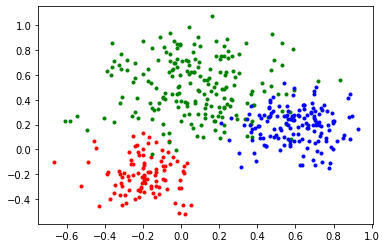

((450, 2), (450,))

In [297]:
X_train, Y_train = generate_data_3classes(100, 200, 150)
X_train.shape, Y_train.shape

In [298]:
Y_cat = to_categorical(Y_train)
Y_cat.shape, Y_cat

((450, 3),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32))

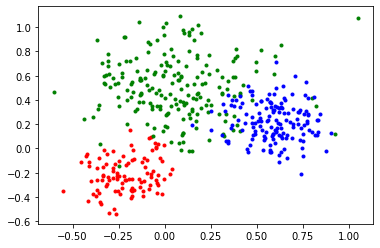

In [299]:
X_train, Y_train = generate_data_3classes(100, 200, 150)
Y_cat = to_categorical(Y_train)

K=Y_cat.shape[1] # nombre de classes
(num_examples, D) = X_train.shape # nombre d'exemples et dimension des exemples

In [300]:
# Fonction sigmoide
def sigmo(v):
	return 1/(1 + np.exp(-v))

# Derivative sigmoid function
def sigmop(v):
	return v * (1 - v)

In [301]:
# Random initialization of weights
W = 1 * np.random.normal(size=(D,K))
b = np.zeros((1,K))

# Learning parameters
step_size = 1e-1
num_iter = 10000

### Part 1: Single layer neural networks  

In this section, we will create a single layer neural network model capable of classifying many different objects (n classes). We will use two different cost functions: **Mean Square Error** and **Log-loss** . The latter are optimized with the **Gradient Decent** algorithm. Then, we will evaluate the performance of our model with the two different cost functions.

In [302]:
## =========== Define the necessary functions =========== ## 

# Calculate the activation of the layer 
def model(X, W, b):
  v = X.dot(W) + b
  y_t = sigmo(v)
  return (y_t, v)

# The log-loss cost function 
def log_loss(y_t, y):
  epsilon = 1e-15
  return 1 / len(y) * np.sum(-y * np.log(y_t + epsilon) - (1 - y) * np.log(1 - y_t + epsilon))

# The derivative of the log-loss cost function 
def gradients_log_loss(y_t, X, y_cat):
  dW = 1/len(y_cat) * np.dot(X.T, y_t - y_cat)
  db = 1/len(y_cat) * np.sum(y_t - y_cat)
  return (dW, db)

# The MSE cost function
def mse_loss(y_t, y_cat):
  err = y_t - y_cat
  return 1/len(y_cat) * np.sum(err**2)

# The derivative of the MSE cost function
def gradients_mse_loss(y_t, X, y_cat):
  err = y_t - y_cat
  dW = 2 * np.dot( X.T, err*sigmop(y_t))
  db = 2 * np.sum(err*sigmop(y_t), axis= 0)
  return (dW, db)

# Update of the network weights by the gradient decent algorithm 
def update_weights(W, b, dW, db, eps=step_size):
  W = W - eps*dW
  b = b - eps*db
  return (W, b)

# Model prediction 
def predict(X, W, b):
  y_t, _ = model(X, W, b)
  return np.argmax(y_t, axis=1) if len(np.unique(y_t)) else y_t >= 0.5


## =============== Help functions ============= ## 

def evaluation_neural_network(X, y, W, b, history):
  """
  Plots the decision boundary created by a model predicting on X
  and evaluation of the cost function as well as the accuracy.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = predict(x_in, W, b).reshape(xx.shape)
  
  # Plot decision boundary
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 3, 1)
  plt.plot(history['losses'], label='losses'); plt.legend()
  plt.title('Cost fuction')
  plt.subplot(1, 3, 2)
  plt.plot(history['accuracy'], label='accuracy'); plt.legend()
  plt.title('Accuracy score')
  plt.subplot(1, 3, 3)
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.title('Decision boundary')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

### Training of the neural network with the log-loss cost function 

In [303]:
X = X_train
Y = Y_train
    
# dictionary containing future accuracy and losses
history = {'losses' : [],
           'accuracy' : []}

for i in range(num_iter):
  # ==== propagation ==== #

  # State of the neurons
  y_t, _ = model(X, W, b)
  # log loss error
  Loss = log_loss(y_t, Y_cat)
  # Save accuracy score and log loss erroe for each iteration in a dictionary
  history['losses'].append(Loss)
  y_pred = predict(X, W, b)
  history['accuracy'].append(accuracy_score(Y.flatten(), y_pred.flatten()))

  if i % 1000 == 0:   
    print('iteration {}: loss {}'.format(i, Loss))
      
  # ==== retro-propagation ==== #

  dL_W, dL_b = gradients_log_loss(y_t, X, Y_cat)
  W, b =  update_weights(W, b, dL_W, dL_b, eps=step_size) 
  


iteration 0: loss 2.237671991930273
iteration 1000: loss 0.7388762037428106
iteration 2000: loss 0.6296538705697472
iteration 3000: loss 0.5877889705571179
iteration 4000: loss 0.5657594283605301
iteration 5000: loss 0.5522869318730508
iteration 6000: loss 0.5432730180122447
iteration 7000: loss 0.5368651540125925
iteration 8000: loss 0.5321043166240794
iteration 9000: loss 0.5284454741679551


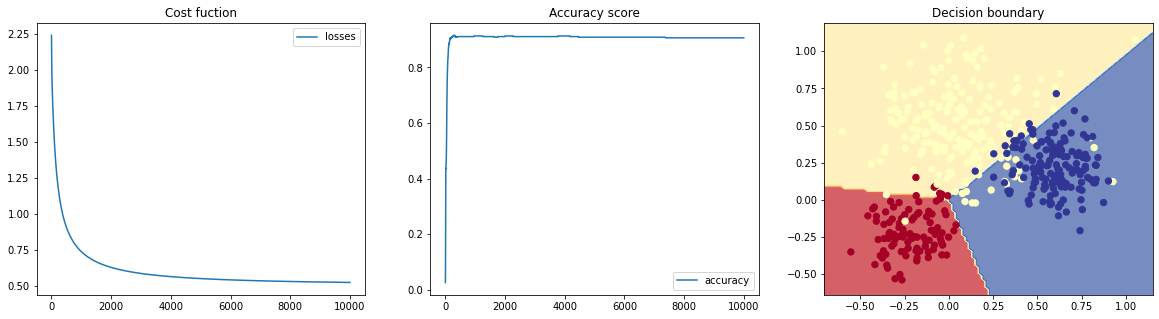

In [304]:
# Evaluation the neural network
evaluation_neural_network(X, Y, W, b, history)

In [305]:
# calculation of accuracy
Y_pred, _ = model(X, W, b)
class_pred = predict(X, W, b)
print('Training accuracy: {:.2}'.format(np.mean(class_pred == Y_train)))

Training accuracy: 0.91


### Training of the neural network with the MSE cost function 

In [306]:
# Random initialization of weights
W = 1 * np.random.normal(size=(D,K))
b = np.zeros((1,K))

# Learning parameters
step_size = 1e-1
num_iter = 20000

X = X_train
Y = Y_train

In [307]:
# dictionary containing future accuracy and losses
history = {'losses' : [],
           'accuracy' : []}

for i in range(num_iter):
  # ==== propagation ==== #

  # State of the neurons
  y_t, _ = model(X, W, b)
  # log loss error
  Loss = mse_loss(y_t, Y_cat)
  # Save accuracy score and log loss erroe for each iteration in a dictionary
  history['losses'].append(Loss)
  y_pred = predict(X, W, b)
  history['accuracy'].append(accuracy_score(Y.flatten(), y_pred.flatten()))

  if i % 1000 == 0:   
    print('iteration {}: loss {}'.format(i, Loss))
      
  # ==== retro-propagation ==== #

  dL_W, dL_b = gradients_mse_loss(y_t, X, Y_cat)
  W, b =  update_weights(W, b, dL_W, dL_b, eps=step_size) 
  


iteration 0: loss 0.8728919282756222
iteration 1000: loss 0.1285922113069415
iteration 2000: loss 0.12813396663479237
iteration 3000: loss 0.12790911243586064
iteration 4000: loss 0.12776978326856483
iteration 5000: loss 0.12767419764253413
iteration 6000: loss 0.12760461974568682
iteration 7000: loss 0.12755192387082798
iteration 8000: loss 0.12751084238419472
iteration 9000: loss 0.127478091275913
iteration 10000: loss 0.12745150644021414
iteration 11000: loss 0.12742960056007283
iteration 12000: loss 0.12741131709897527
iteration 13000: loss 0.1273958851817813
iteration 14000: loss 0.12738272976525103
iteration 15000: loss 0.12737141380720082
iteration 16000: loss 0.1273615998002356
iteration 17000: loss 0.12735302346935173
iteration 18000: loss 0.12734547535579122
iteration 19000: loss 0.12733878765480408


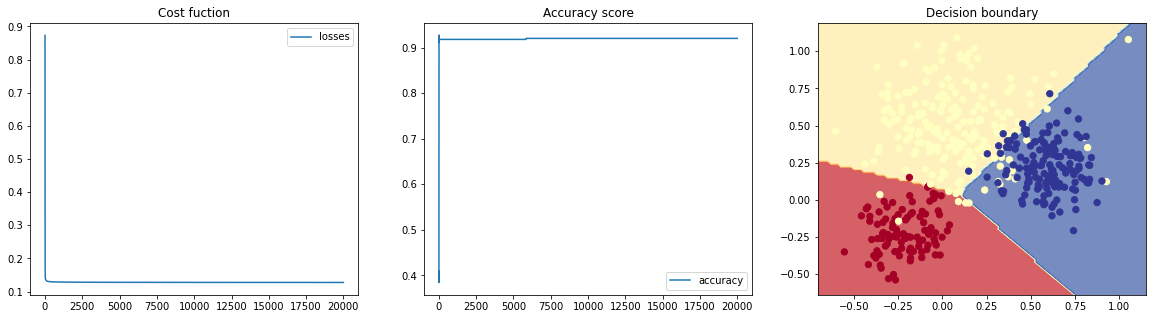

In [308]:
# Evaluation the neural network
evaluation_neural_network(X, Y, W, b, history)

In [309]:
# Calculation of accuracy
Y_pred, _ = model(X, W, b)
class_pred = predict(X, W, b)
print('Training accuracy: {:.2}'.format(np.mean(class_pred == Y_train)))

Training accuracy: 0.92


# Note
The model learns very well to classify the data in the training database. The two cost functions used give similar results on the accuracy of the model. But, we quickly realize that over a very small number of iterations, our model can no longer improve its pressure. If we look at the decision boundary of our model, we see that it separates the three classes with straight lines (linear model), except that our data are not linearly distributed.  To have a chance to improve the accuracy of the model, we need to add hidden layers of neural networks (non linear model). This is the subject of the rest of this tutorial.

# Go further

To go further: 
- performance evaluation (and visualization) code
- create an independent test set (generalization performance)
- add a hidden layer (observe performance gains and decision boundaries)

In this section, we will create a two-layer neural network model (a hidden layer of 8 neurons and an output layer of 3 neurons) capable of classifying many different objects. We will use **log-loss** as a cost function. The latter is optimized using the **decent gradient** algorithm. Then, we will evaluate the performance of our model, against training and test data.

### Part 2: Two-layer neural network   

To evaluate the robustness of our model, we need to test it on examples that it has never seen, hence the interest of dividing our database into **Training data** and **Test data**.

In [310]:
# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, y_train.shape, y_test.shape

((360, 2), (360,), (90,))

In [311]:
# To_categorical et reshape
Y_cat = to_categorical(y_train)
Y_cat_test = to_categorical(y_test)


K = Y_cat.shape[1] # number of classes
D, m = X_train.shape # size of the examples and number of examples

# Random initialization of weights with two hidden layer 
length_hidden_layer = 8
np.random.seed(0)
W = {'W1' : np.random.normal(size=(length_hidden_layer, m)),
     'W2' : np.random.normal(size=(K, length_hidden_layer))}
b = {'b1' : np.zeros((length_hidden_layer, 1)),
     'b2' : np.zeros((K, 1))}

# Lirning parameters
step_size = 1e-1
num_iter = 10000

In [313]:
## =========== Define the necessary functions =========== ## 

# The log-loss cost function 
def log_loss(transitions, y_cat):
  epsilon = 1e-15
  return 1 / len(y_cat) * np.sum(-y_cat.T * np.log(transitions['A2'] + epsilon) - (1 - y_cat.T) * np.log(1 - transitions['A2'] + epsilon))

# Forward probagation
def forward_probagation(X, W, b):
  Z1 = W['W1'].dot(X.T) + b['b1']
  A1 = sigmo(Z1)
  Z2 = W['W2'].dot(A1) + b['b2']
  A2 = sigmo(Z2)
  transitions = {
                  'A1':A1, 
                  'A2':A2
                }
  return transitions

# Back propagation
def back_propagation(X, y_cat, W, transitions):
  m = len(y_cat)
  dZ2 = transitions['A2'] - y_cat.T
  dW2 = 1 / m * dZ2.dot(transitions['A1'].T)
  db2 = 1 / m * np.sum(dZ2, axis=1, keepdims = True)
  dZ1 = np.dot(W['W2'].T, dZ2) * transitions['A1'] * (1 - transitions['A1'])
  dW1 = 1 / m * dZ1.dot(X)
  db1 = 1 / m * np.sum(dZ1, axis=1, keepdims = True)
  gradients = {
                'dW1' : dW1,
                'db1' : db1,
                'dW2' : dW2,
                'db2' : db2
              }
    
  return gradients

# Update weights
def update_weights(W, b, gradients):
  W['W1'] = W['W1'] - step_size * gradients['dW1']
  b['b1'] = b['b1'] - step_size * gradients['db1']
  W['W2'] = W['W2'] - step_size * gradients['dW2']
  b['b2'] = b['b2'] - step_size * gradients['db2']

  return (W, b)

# Model prediction 
def predict(X, W, b):
  translation = forward_probagation(X, W, b)
  return np.argmax(translation['A2'], axis=0) if len(np.unique(translation['A2']))>2 else translation['A2'] >= 0.5


### Learning network

In [314]:
# Learning network

# dictionary containing future accuracy and losses
traning_history = {'losses'   : [],
                   'accuracy' : []}

testing_history = {'losses'   : [],
                   'accuracy' : []}

num_iter = 10000
for i in tqdm(range(num_iter)):
    # Forward probagation
    transitions = forward_probagation(X_train, W, b)

    # Back propagation
    gradients = back_propagation(X_train, Y_cat, W, transitions)

    # Update weights
    W, b = update_weights(W, b, gradients)
   
    # if i % 100 == 0:   
    #     print('iteration {}: loss {}'.format(i, Loss))

    # Predictions model
    class_train_pred = predict(X_train, W, b)
    class_test_pred = predict(X_test, W, b)

    # # Remplit le vecteur de loss et acc
    traning_history['losses'].append(log_loss(transitions, Y_cat))
    traning_history['accuracy'].append(accuracy_score(y_train.flatten(), class_train_pred.flatten()))
    testing_history['losses'].append(log_loss(forward_probagation(X_test, W, b), Y_cat_test))
    testing_history['accuracy'].append(accuracy_score(y_test.flatten(), class_test_pred.flatten()))

100%|██████████| 10000/10000 [00:07<00:00, 1384.35it/s]


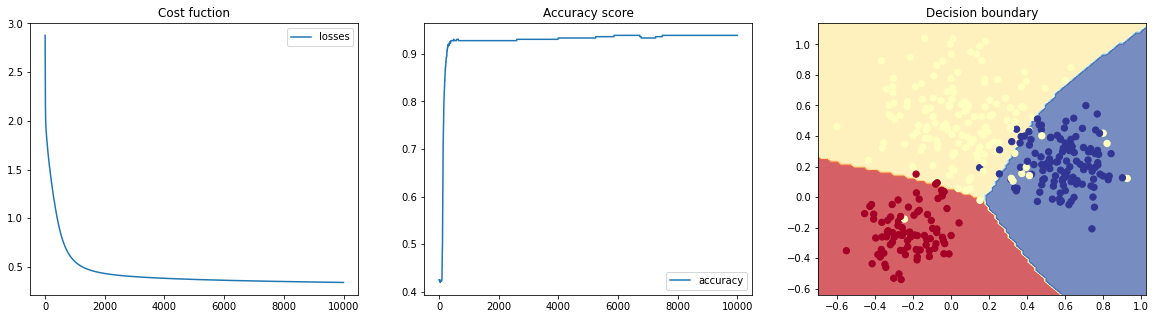

In [315]:
# Evaluation of the model against the training data 
evaluation_neural_network(X_train, y_train, W, b, traning_history)

In [316]:
# Calculation of accuracy
print('Training accuracy: {:.2}'.format(np.mean(class_train_pred == y_train)))

Training accuracy: 0.94


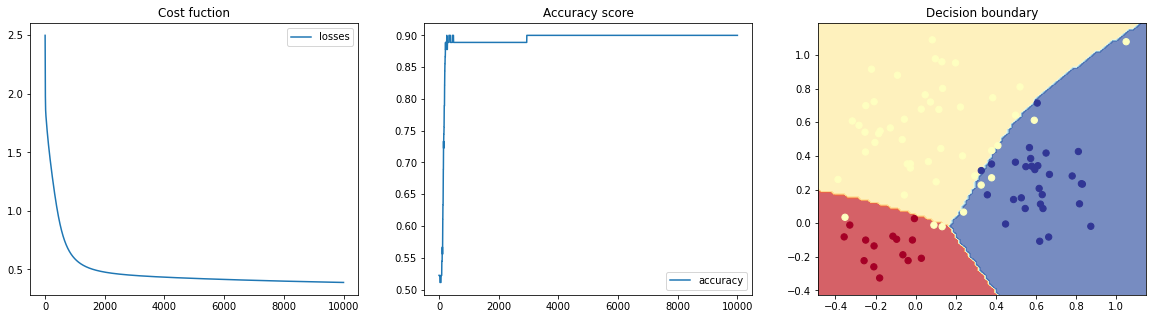

In [318]:
# Evaluation of the model against the training data 
evaluation_neural_network(X_test, y_test, W, b, testing_history)

In [319]:
# Calculation of accuracy
print('Training accuracy: {:.2}'.format(np.mean(class_test_pred == y_test)))

Training accuracy: 0.9


### Note
With a two-layer neural network we can have a non-linear decision frontier that better fits our classification problem. With a hidden layer of 8 neurons and an output layer of 3 neurons, we have gained 2% of percions in the training base (which is already quite a lot). To try to improve our model, we create additional layers of neurons while evaluating the model with the training base and the test base to avoid overlearning.